In [1]:
# Importing our dependencies
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import hvplot.pandas

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import tree
import joblib
import tensorflow as tf

from pyspark.sql import SparkSession
import warnings
warnings.filterwarnings('ignore')

## 1. Loading our data

In [2]:
# Creating a spark session to read our data
spark = SparkSession \
    .builder \
    .appName("Python Spark") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/11/14 19:56:09 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
# Assign our spark dataframes to variables

red = spark.read.csv("Resources/winequality-red.csv", sep=";", header=True)
white = spark.read.csv("Resources/winequality-white.csv", sep=";", header=True)

#red.show(5)
white.show(5)

+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+
|fixed acidity|volatile acidity|citric acid|residual sugar|chlorides|free sulfur dioxide|total sulfur dioxide|density|  pH|sulphates|alcohol|quality|
+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+
|            7|            0.27|       0.36|          20.7|    0.045|                 45|                 170|  1.001|   3|     0.45|    8.8|      6|
|          6.3|             0.3|       0.34|           1.6|    0.049|                 14|                 132|  0.994| 3.3|     0.49|    9.5|      6|
|          8.1|            0.28|        0.4|           6.9|     0.05|                 30|                  97| 0.9951|3.26|     0.44|   10.1|      6|
|          7.2|            0.23|       0.32|           8.5|    0.058|                 47|           

In [4]:
# Converting our spark dataframes to pandas dataframes
red_df = red.toPandas()
white_df = white.toPandas()

#red_df.head()
white_df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7,0.27,0.36,20.7,0.045,45,170,1.001,3,0.45,8.8,6
1,6.3,0.3,0.34,1.6,0.049,14,132,0.994,3.3,0.49,9.5,6
2,8.1,0.28,0.4,6.9,0.05,30,97,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47,186,0.9956,3.19,0.4,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47,186,0.9956,3.19,0.4,9.9,6


In [5]:
# Adding a type column to both our dataframes to provide binary identifiers for red & white wine
red_df["type"]="red"
white_df["type"]="white"

# Zipping both tables to create a table complete with quality and feature data for red & white wine
zipped_wine = pd.concat([red_df, white_df], axis=0)
zipped_wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type
0,7.4,0.7,0,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5,red
1,7.8,0.88,0,2.6,0.098,25,67,0.9968,3.2,0.68,9.8,5,red
2,7.8,0.76,0.04,2.3,0.092,15,54,0.997,3.26,0.65,9.8,5,red
3,11.2,0.28,0.56,1.9,0.075,17,60,0.998,3.16,0.58,9.8,6,red
4,7.4,0.7,0,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5,red


In [6]:
# Analyzing the data types of out columns
zipped_wine.dtypes

fixed acidity           object
volatile acidity        object
citric acid             object
residual sugar          object
chlorides               object
free sulfur dioxide     object
total sulfur dioxide    object
density                 object
pH                      object
sulphates               object
alcohol                 object
quality                 object
type                    object
dtype: object

In [7]:
# Since our columns data are objects, we need to convert them to floats and integers.
zipped_wine["fixed acidity"] = zipped_wine["fixed acidity"].astype("float64")
zipped_wine["volatile acidity"] = zipped_wine["volatile acidity"].astype("float64")
zipped_wine["citric acid"] = zipped_wine["citric acid"].astype("float64")
zipped_wine["residual sugar"] = zipped_wine["residual sugar"].astype("float64")
zipped_wine["chlorides"] = zipped_wine["chlorides"].astype("float64")
zipped_wine["total sulfur dioxide"] = zipped_wine["total sulfur dioxide"].astype("float64")
zipped_wine["free sulfur dioxide"] = zipped_wine["free sulfur dioxide"].astype("float64")
zipped_wine["density"] = zipped_wine["density"].astype("float64")
zipped_wine["pH"] = zipped_wine["pH"].astype("float64")
zipped_wine["sulphates"] = zipped_wine["sulphates"].astype("float64")
zipped_wine["alcohol"] = zipped_wine["alcohol"].astype("float64")

zipped_wine["quality"] = zipped_wine["quality"].astype("int64")

# Confirming the change to data types went through
zipped_wine.dtypes

fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
type                     object
dtype: object

## 2. Analyzing our data

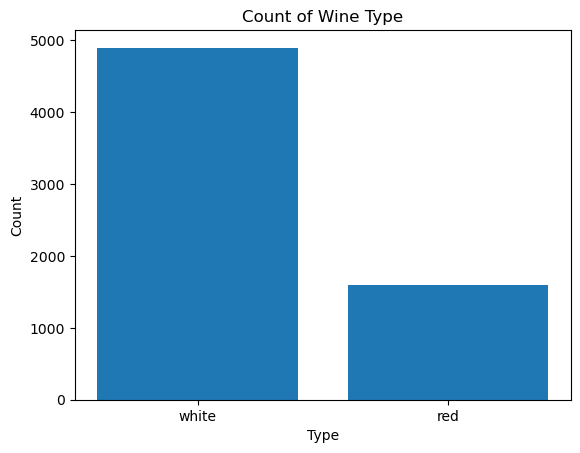

In [8]:
# Creating a bar graph to show us how our wine type is distributed
wine_types = zipped_wine["type"].value_counts()

plt.bar(wine_types.index, wine_types.values)
plt.xlabel("Type")
plt.ylabel("Count")
plt.title("Count of Wine Type")

plt.savefig("Images/wine_count.png")
plt.show()

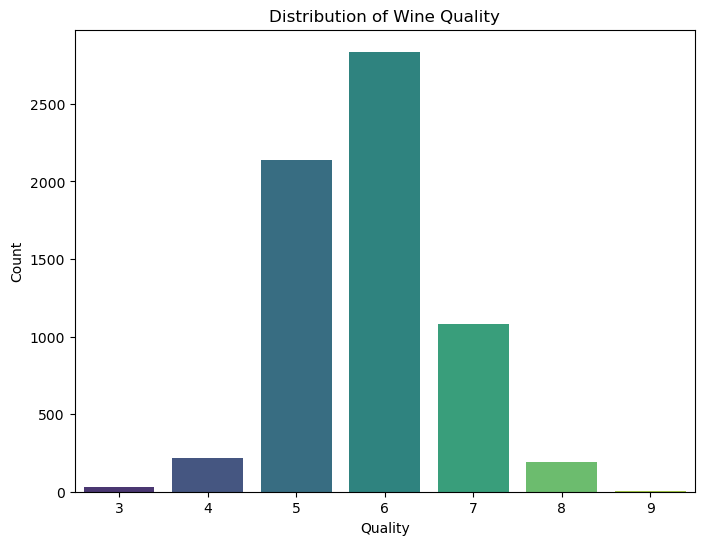

In [9]:
# Creating another bar graph to show us how our wine is distributed by its quality
plt.figure(figsize=(8, 6))
sns.countplot(x='quality', data=zipped_wine, palette='viridis')
plt.title('Distribution of Wine Quality')
plt.xlabel('Quality')
plt.ylabel('Count')
plt.savefig("Images/wine_quality_distribution.png")
plt.show()

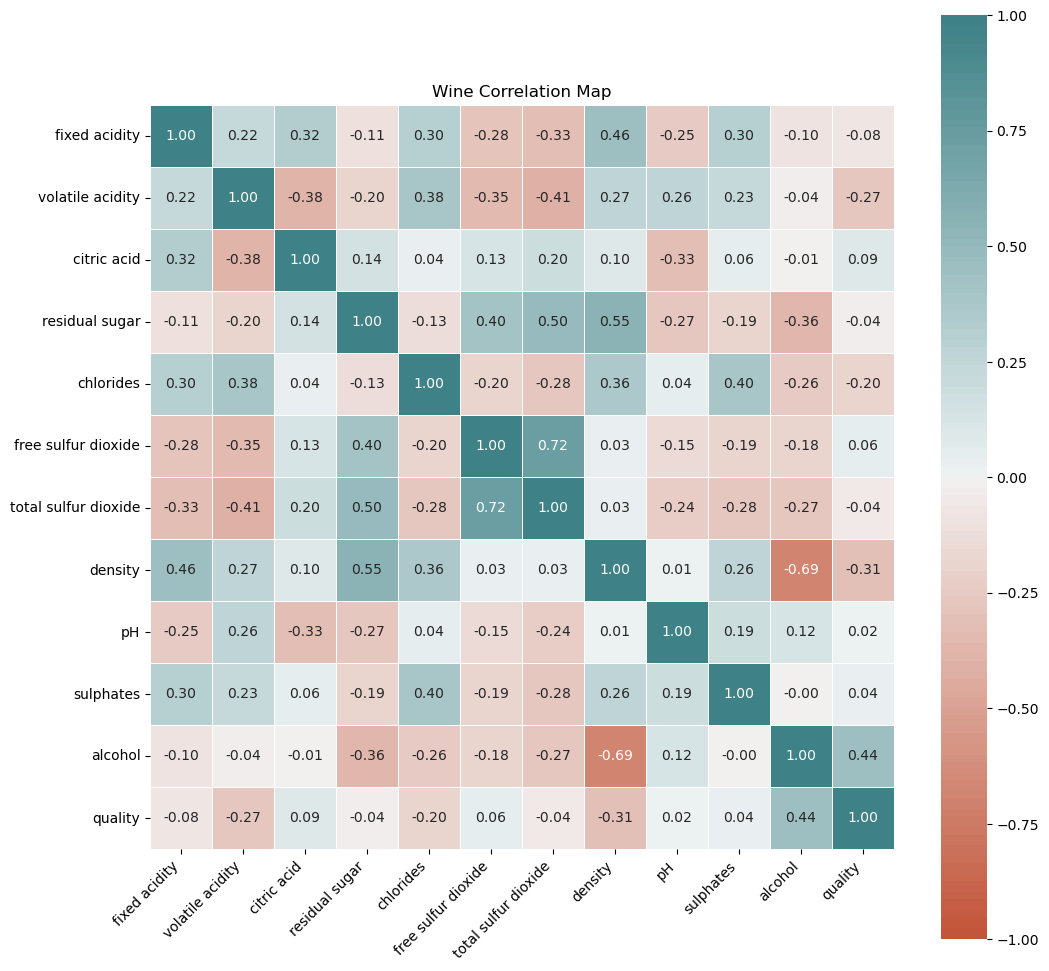

In [10]:
# In order to see how quality is affected by multiple components in the wine, we're creating a correlation map to analyze the relationship.
num_wine = zipped_wine.drop(columns=["type"])
corr = num_wine.corr()

plt.figure(figsize=(12, 12))
ax = sns.heatmap(corr,
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 200, sep=1, n=100, l=50),
    square=True,
    annot=True,  # Add annotations
    fmt=".2f",   # Format for annotations
    linewidths=.5,
    xticklabels=True,
    yticklabels=True)

ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=10, rotation=45, ha='right')
ax.set_title("Wine Correlation Map")

plt.savefig("Images/wine_correlation.png")
plt.show()

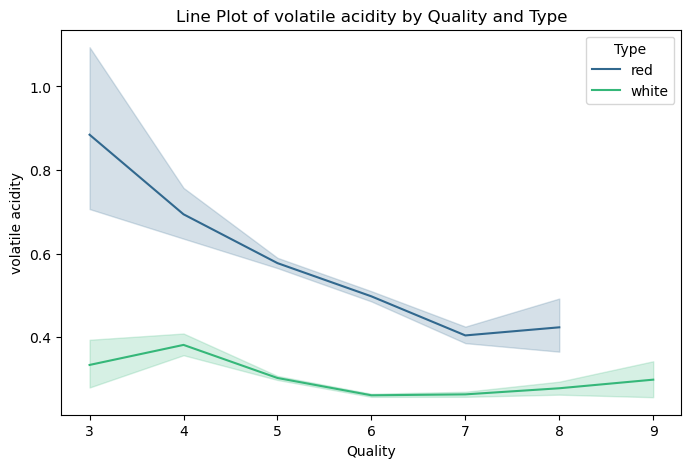

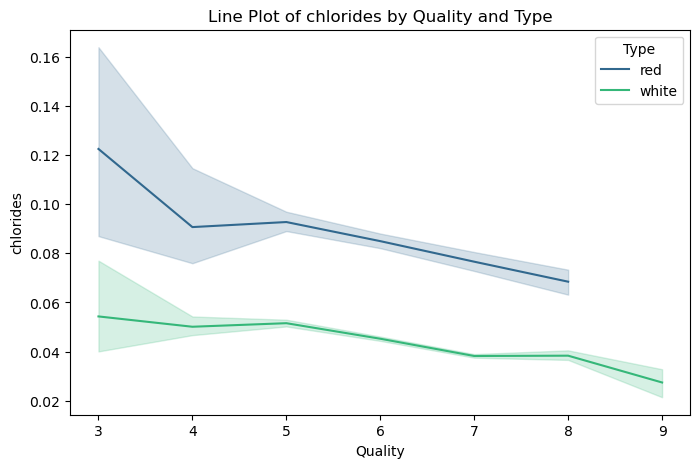

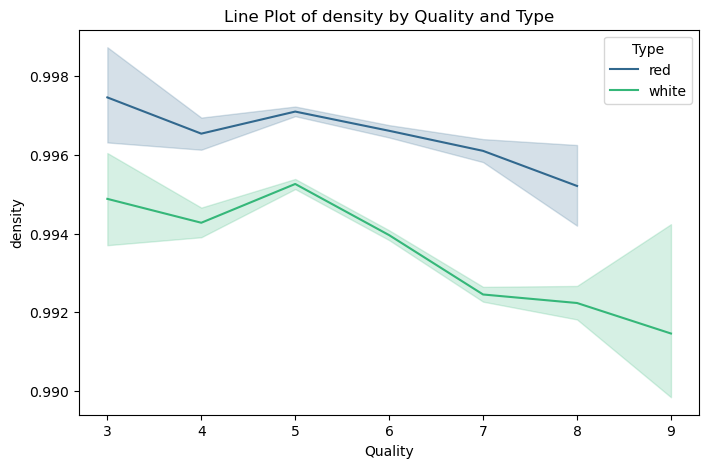

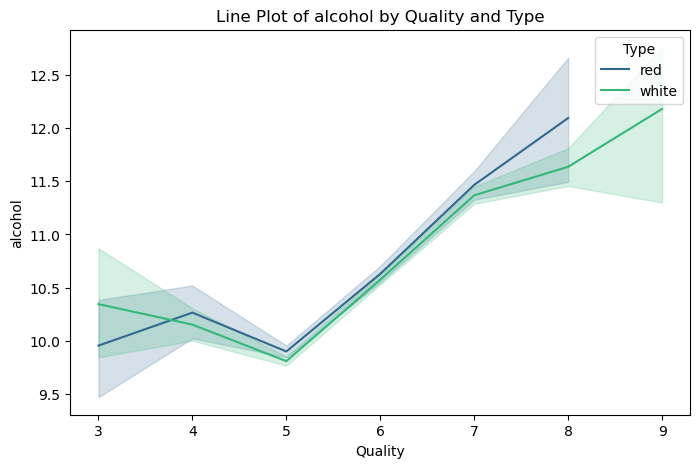

In [11]:
# Next we take the top 4 features that have the most positive or negative correlation with quality, and analyze how these relationships look given the type of wine.
selected_columns = ["volatile acidity", "chlorides", "density", "alcohol", "type", "quality"]

# Creating a loop to create the line graphs for each feature in our selected_columns list
for feature in selected_columns[:-2]:  # Exclude 'type' and 'quality' from the loop
    plt.figure(figsize=(8, 5))
    sns.lineplot(x='quality', y=feature, hue='type', data=zipped_wine, palette='viridis')
    plt.title(f'Line Plot of {feature} by Quality and Type')
    plt.xlabel('Quality')
    plt.ylabel(feature)
    plt.legend(title='Type')
    plt.savefig(f"Images/wine_lineplot_{feature}.png")
    plt.show()

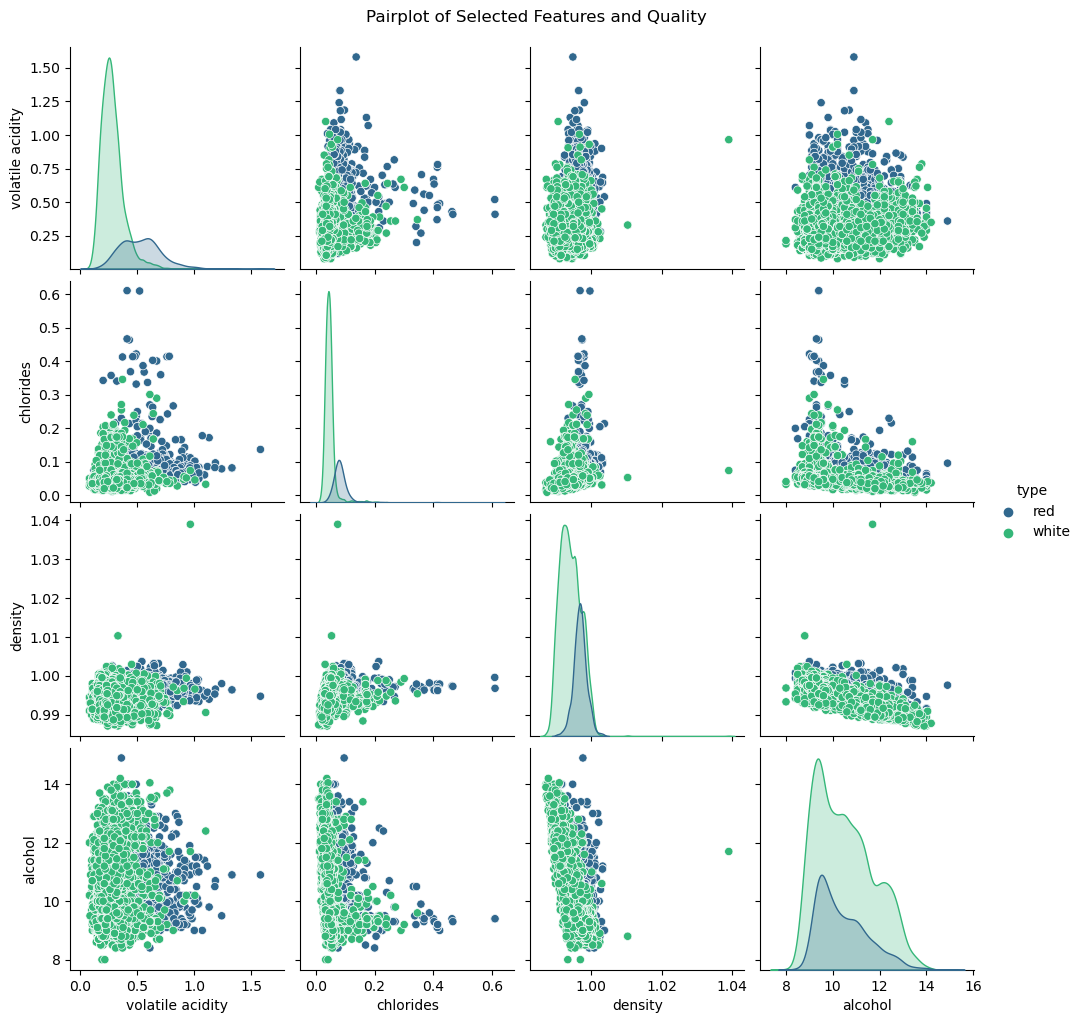

In [12]:
# With those same selected features, we're creating a pair plot to show us in detail how these relationships appear around different types of wine.
selected_columns = ["volatile acidity", "chlorides", "density", "alcohol", "type"]

# Creating the pairplot with kernel density plots on diagonal
sns.pairplot(zipped_wine[selected_columns], hue='type', palette='viridis')
plt.suptitle('Pairplot of Selected Features and Quality', y=1.02)
plt.savefig("Images/wine_pairplot.png")
plt.show()

## 3. PCA Clustering for our selected features

In [13]:
# We begin by selecting our top features and scaling the data
selected_columns_for_pca = ["volatile acidity", "chlorides", "density", "alcohol"]

# Extracting selected columns for PCA
pca_data = zipped_wine[selected_columns_for_pca]

# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(pca_data)

# Perform PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_data)

# Analyzing the variance in our data
pca.explained_variance_ratio_


array([0.50939993, 0.27237962])

In [14]:
# Creating a DataFrame with the PCA results
pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])

# Setting the original index as wine_id
pca_df["wine_id"]=zipped_wine.index

# Set the wine_id column as index
pca_df = pca_df.set_index("wine_id")

# Display sample data
pca_df.head()

,PC1,PC2
wine_id,,
0,2.153326,1.020119
1,2.450781,2.304857
2,2.155356,1.706221
3,1.108595,-0.624616
4,2.153326,1.020119


In [15]:
# We opted 3 clusters to look at how our PCA data is clustered.
# Creating the model
model = KMeans(n_clusters=3,random_state=1)

# Fitting the model to the PCA data
model.fit(pca_df)

# Alloting clusters for each wine_id
clusters = model.predict(pca_df)

# Printing the cluster data
clusters

array([2, 2, 2, ..., 0, 1, 1], dtype=int32)

In [16]:
# Adding a wine_clusters column to show us which cluster each wine belongs to
pca_df_copy = pca_df.copy()

pca_df_copy["wine_clusters"] = clusters

pca_df_copy.head()

,PC1,PC2,wine_clusters
wine_id,,,
0,2.153326,1.020119,2
1,2.450781,2.304857,2
2,2.155356,1.706221,2
3,1.108595,-0.624616,0
4,2.153326,1.020119,2


In [17]:
# Plotting our cluster plot
wine_pca_plot = pca_df_copy.hvplot.scatter(
    x="PC1",
    y="PC2",
    by="wine_clusters",
    title="PCA Clustering",
    hover_cols="wine_id"
)

wine_pca_plot


:NdOverlay   [wine_clusters]
   :Scatter   [PC1]   (PC2,wine_id)

## 4. Using a Supervised Learning model to predict the type of wine and quality given various testing features.

Using Random Classifier Model for predicting Wine type

In [18]:
# First we convert our type data into binary classifiers, 0 for red wine and 1 for white
zipped_wine.loc[(zipped_wine["type"]=="red"), "type"]=0
zipped_wine.loc[(zipped_wine["type"]=="white"), "type"]=1

# Checking if the change went through
zipped_wine["type"].value_counts()

type
1    4898
0    1599
Name: count, dtype: int64

In [19]:
# Changing the data type for the "type" column to an integer
zipped_wine["type"] = zipped_wine["type"].astype("int64")

For this purpose, we selected the Random Forest Classifier model to build a decision tree of how the quantity of each feature affects what type of wine it is.

In [20]:
# Separate features (X) and target variable (y)
X = zipped_wine.drop('type', axis=1)  # Features
y = zipped_wine['type']  # Target variable

# Splitting into Train and Test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=45)

# Creating StandardScaler instance
scaler = StandardScaler()

# Fitting Standard Scaler
X_scaler = scaler.fit(X_train)

# Scaling data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

# Create a Random Forest Classifier model
rf_model = RandomForestClassifier(n_estimators=500, random_state=45, max_depth=10, max_samples=2000)

# Fitting the model
model_fitted = rf_model.fit(X_train_scaled, y_train)

# Making predictions using the testing data
predictions = model_fitted.predict(X_test_scaled)

# Calculating the accuracy score
acc_score = accuracy_score(y_test, predictions)

# Using joblib to save the trained model
joblib.dump(model_fitted, 'Models/random_forest_model.pkl')

# Displaying results
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, predictions))

Accuracy Score : 0.9913846153846154
Classification Report
              precision    recall  f1-score   support

           0       1.00      0.97      0.98       421
           1       0.99      1.00      0.99      1204

    accuracy                           0.99      1625
   macro avg       0.99      0.98      0.99      1625
weighted avg       0.99      0.99      0.99      1625



Our Random Forest Classifier model performs extremely well in this case. A source published by the University of California, Davis (linked under Sources in our READMe file) speaks extensively on the accuracy of the Random Forest model when training our dataset. This can confirm that there is no leakage in our dataset.

In [21]:
# Analyzing which features heavily affect how our model is trained
features =zip(rf_model.feature_importances_, X.columns)
for f in features:
    print(f)

(0.04513078948024463, 'fixed acidity')
(0.12333345951398174, 'volatile acidity')
(0.018487450410358507, 'citric acid')
(0.04392062985234628, 'residual sugar')
(0.25744817431101574, 'chlorides')
(0.056207496079502706, 'free sulfur dioxide')
(0.30719924300096435, 'total sulfur dioxide')
(0.06239224356008394, 'density')
(0.020902815083640947, 'pH')
(0.053441514980989445, 'sulphates')
(0.008575257719671284, 'alcohol')
(0.0029609260072005397, 'quality')


<Axes: title={'center': 'Features Importances in Wine'}, ylabel='1'>

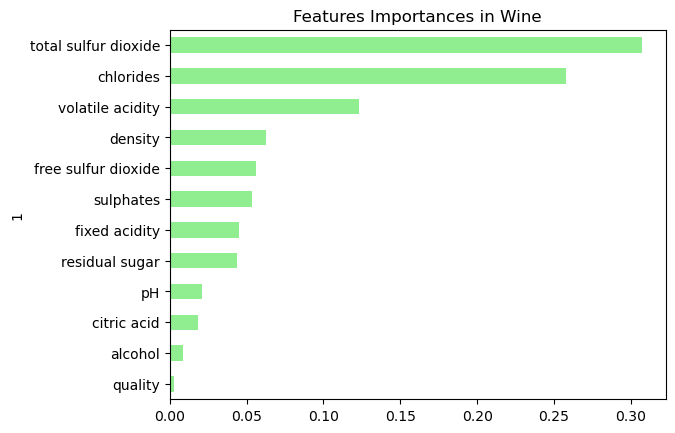

In [22]:
# Plotting our feature importances
importances_df = pd.DataFrame(sorted(zip(rf_model.feature_importances_, X.columns), reverse=True))
importances_df.set_index(importances_df[1], inplace=True)
importances_df.drop(columns=1, inplace=True)
importances_df.rename(columns={0: 'Feature Importances'}, inplace=True)
importances_sorted = importances_df.sort_values(by='Feature Importances')
importances_sorted.plot(kind='barh', color='lightgreen', title= 'Features Importances in Wine', legend=False)


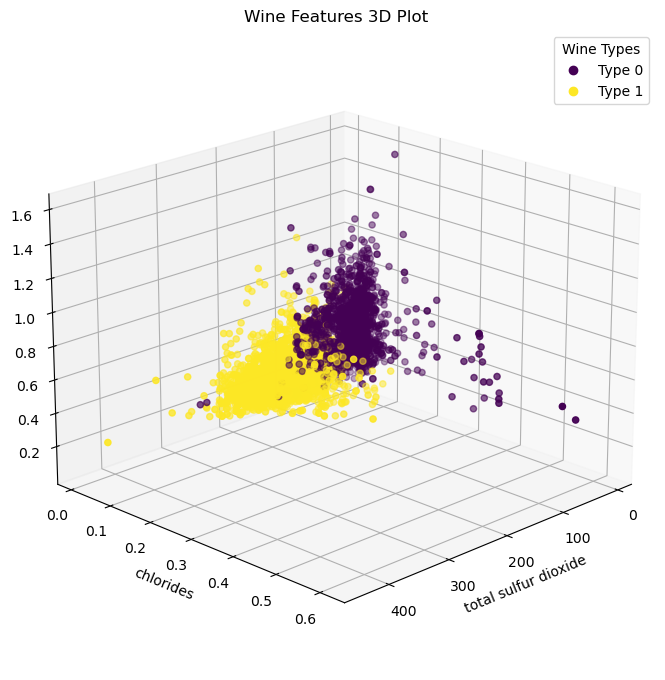

In [28]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Assuming 'zipped_wine' is your DataFrame containing the wine data

# Plotting our top 3 feature importances in a 3D plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(projection='3d')

f1 = "total sulfur dioxide"
f2 = "chlorides"
f3 = "volatile acidity"

# Scatter plot with legend
scatter = ax.scatter(zipped_wine[f1], zipped_wine[f2], zipped_wine[f3], c=zipped_wine["type"])

# Create a legend
legend_labels = ["Type 0", "Type 1"]  # Assuming 'type' has values 0 and 1
handles, _ = scatter.legend_elements()
ax.legend(handles, legend_labels, title="Wine Types", loc="upper right")

ax.set_xlabel(f1)
ax.set_ylabel(f2)
ax.set_zlabel(f3)
ax.set_title("Wine Features 3D Plot")
ax.dist = 10

# Adjusting margins
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)

# Increasing z-axis label padding
ax.zaxis.labelpad = 15

ax.view_init(elev=20, azim=45)

plt.savefig("Images/wine_features_3dplot.png")
plt.show()


In [30]:
# Creating our decision tree to further analyze how the data is used in predicting wine types
fig = plt.figure(figsize=(50,15))
_ = tree.plot_tree(model_fitted[5],
                   feature_names=X_train.columns,
                   class_names=["red","white"],
                   filled=True)

plt.savefig("Images/wine_decision_tree.png", dpi=300)

Using Random Classifier Model for predicting Wine quality

In [31]:
# Creating a copy of our dataframe
copy_wine = zipped_wine.copy()
copy_wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,0
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0


In [32]:
# Binning our quality data into 3 separate bins, 0=below average, 1=average and 2=above average
copy_wine.loc[(copy_wine["quality"]<=5),"quality"]=0
copy_wine.loc[(copy_wine["quality"]==6),"quality"]=1
copy_wine.loc[(copy_wine["quality"]>6),"quality"]=2

# Checking our bin classification
copy_wine["quality"].value_counts()

quality
1    2836
0    2384
2    1277
Name: count, dtype: int64

In [33]:
# Dropping our type column
copy_wine = copy_wine.drop(columns="type")
copy_wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,1
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0


In [34]:
# Separate features (X) and target variable (y)
X = copy_wine.drop('quality', axis=1)  # Features
y = copy_wine['quality']  # Target variable


# Splitting into Train and Test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=45)

# Creating StandardScaler instance
scaler = StandardScaler()

# Fitting Standard Scaller
X_scaler = scaler.fit(X_train)

# Scaling data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

# Create a Random Forest Regressor model
rf_model = RandomForestClassifier(n_estimators=1000, random_state=50, max_depth=20, max_samples=4872)

# Fitting the model
rf_model = rf_model.fit(X_train_scaled, y_train)

# Making predictions using the testing data
predictions = rf_model.predict(X_test_scaled)

# Calculating the accuracy score
acc_score = accuracy_score(y_test, predictions)

# Displaying results
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, predictions))

Accuracy Score : 0.7298461538461538
Classification Report
              precision    recall  f1-score   support

           0       0.81      0.74      0.77       617
           1       0.65      0.77      0.71       670
           2       0.80      0.62      0.70       338

    accuracy                           0.73      1625
   macro avg       0.75      0.71      0.73      1625
weighted avg       0.74      0.73      0.73      1625



(0.0731316645253661, 'fixed acidity')
(0.10297414675291919, 'volatile acidity')
(0.07973245552034895, 'citric acid')
(0.08243755968892658, 'residual sugar')
(0.08591858415113154, 'chlorides')
(0.08444736650584374, 'free sulfur dioxide')
(0.08952905096594149, 'total sulfur dioxide')
(0.10149311162480831, 'density')
(0.08192020738521266, 'pH')
(0.08325271865654105, 'sulphates')
(0.13516313422296045, 'alcohol')


<Axes: title={'center': 'Features Importances in Wine'}, ylabel='1'>

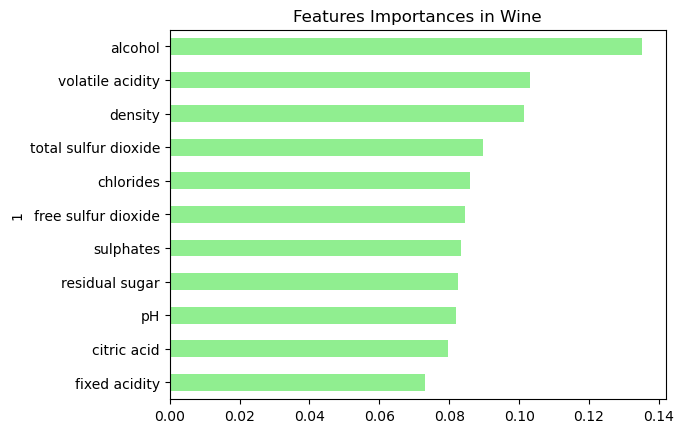

In [35]:
# Analyzing which features heavily affect how our model is trained
features =zip(rf_model.feature_importances_, X.columns)
for f in features:
    print(f)

# Plotting our feature importances
importances_df = pd.DataFrame(sorted(zip(rf_model.feature_importances_, X.columns), reverse=True))
importances_df.set_index(importances_df[1], inplace=True)
importances_df.drop(columns=1, inplace=True)
importances_df.rename(columns={0: 'Feature Importances'}, inplace=True)
importances_sorted = importances_df.sort_values(by='Feature Importances')
importances_sorted.plot(kind='barh', color='lightgreen', title= 'Features Importances in Wine', legend=False)


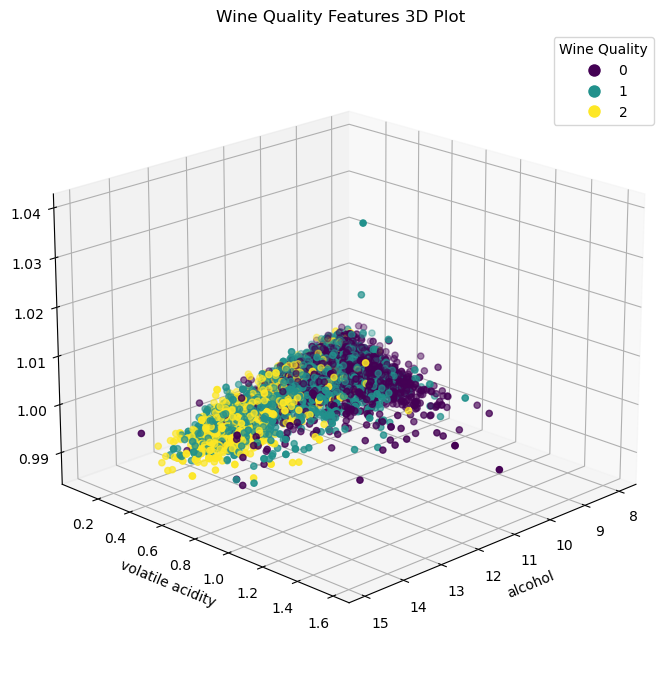

In [37]:
# Plotting our top 3 feature importances in a 3D plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(projection='3d')

f1 = "alcohol"
f2 = "volatile acidity"
f3 = "density"
scatter = ax.scatter(copy_wine[f1], copy_wine[f2], copy_wine[f3], c=copy_wine["quality"])

# Create a legend
legend_labels = copy_wine["quality"].unique()
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=scatter.to_rgba(legend_label), markersize=10) for legend_label in legend_labels]
ax.legend(handles, legend_labels, title="Wine Quality", loc="upper right")

ax.set_xlabel(f1)
ax.set_ylabel(f2)
ax.set_zlabel(f3)
ax.set_title("Wine Quality Features 3D Plot")
ax.dist=10

# Adjusting margins
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)

# Increasing z-axis label padding
ax.zaxis.labelpad = 15

ax.view_init(elev=20,azim=45)

plt.savefig("Images/wine_quality_features_3dplot.png")
plt.draw()

In [ ]:
# fig = plt.figure(figsize=(50,15))
# _ = tree.plot_tree(rf_model[5],
#                    feature_names=X_train.columns,
#                    class_names=["below average","average","above average"],
#                    filled=True)

# plt.savefig("Images/wine_quality_decision_tree.png", dpi=300)

## 5. Using a Neural Network (Deep Learning Model) to predict the quality of our wine.

In [38]:
# Double checking our zipped data

zipped_wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,0
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0


In [39]:
# Analyzing how our wine quality is distributed. It looks like the highest quality is 9 and the lowest is 3.
zipped_wine["quality"].value_counts()

quality
6    2836
5    2138
7    1079
4     216
8     193
3      30
9       5
Name: count, dtype: int64

In [40]:
# We're creating bins for our wine to label them as 0 = bad, and 1=good
zipped_wine['wine_category'] = pd.cut(zipped_wine['quality'], bins=[2, 5, 10], labels=[0, 1], include_lowest=True)

# Dropping the quality and type column as they are no longer required. (categorical variables)
zipped_wine_copy = zipped_wine.copy()
zipped_wine_copy = zipped_wine_copy.drop(columns = ["quality", "type"])
zipped_wine_copy["wine_category"]=zipped_wine_copy["wine_category"].astype("int64")

zipped_wine_copy.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,wine_category
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,1
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0


In [41]:
# Checking data types once more
zipped_wine_copy.dtypes

fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
wine_category             int64
dtype: object

In [42]:
# Scaling data before applying neural network
# Separate features (X) and target variable (y)
X = zipped_wine_copy.drop('wine_category', axis=1)  # Features
y = zipped_wine_copy['wine_category']  # Target variable


# Splitting into Train and Test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=45)

# Creating StandardScaler instance
scaler = StandardScaler()

# Fitting Standard Scaller
X_scaler = scaler.fit(X_train)

# Scaling data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [43]:
# Creating our neural network model
nn = tf.keras.models.Sequential()

# Assigning number of features and neurons. We're using 3 layers as a first start
input_features = len(X_train_scaled[0])
hidden_nodes1=20
hidden_nodes2=10
hidden_nodes3=8

# First hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes1, input_dim=input_features, activation='relu'))

# Second hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes2, activation='relu'))

nn.add(tf.keras.layers.Dense(units=hidden_nodes3, activation='sigmoid'))

# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

# Check the structure of the model
nn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 20)                240       
                                                                 
 dense_1 (Dense)             (None, 10)                210       
                                                                 
 dense_2 (Dense)             (None, 8)                 88        
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 547 (2.14 KB)
Trainable params: 547 (2.14 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


#### 1st Attempt

In [44]:
# Compile the model
nn.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])

In [45]:
# Train the model
fit_model = nn.fit(X_train_scaled, y_train, epochs=30)

Epoch 1/30
153/153 [==============================] - 0s 588us/step - loss: 0.6295 - accuracy: 0.6392
Epoch 2/30
153/153 [==============================] - 0s 499us/step - loss: 0.5620 - accuracy: 0.6972
Epoch 3/30
153/153 [==============================] - 0s 472us/step - loss: 0.5264 - accuracy: 0.7408
Epoch 4/30
153/153 [==============================] - 0s 482us/step - loss: 0.5141 - accuracy: 0.7500
Epoch 5/30
153/153 [==============================] - 0s 481us/step - loss: 0.5076 - accuracy: 0.7508
Epoch 6/30
153/153 [==============================] - 0s 471us/step - loss: 0.5024 - accuracy: 0.7555
Epoch 7/30
153/153 [==============================] - 0s 463us/step - loss: 0.4988 - accuracy: 0.7590
Epoch 8/30
153/153 [==============================] - 0s 459us/step - loss: 0.4960 - accuracy: 0.7611
Epoch 9/30
153/153 [==============================] - 0s 451us/step - loss: 0.4931 - accuracy: 0.7588
Epoch 10/30
153/153 [==============================] - 0s 469us/step - loss: 0.489

In [46]:
# Saving our model in an H5 file
nn.save('Models/neural_network_model.h5')

In [47]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled, y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

51/51 - 0s - loss: 0.4747 - accuracy: 0.7920 - 86ms/epoch - 2ms/step
Loss: 0.47469690442085266, Accuracy: 0.7919999957084656


From the above data, it's apparent that our deep learning model has a pretty good accuracy score of above 75%

#### 2nd Attempt

In [48]:
# Creating our neural network model
nn_1 = tf.keras.models.Sequential()

# Assigning number of features and neurons. We're using 3 layers as a first start
input_features = len(X_train_scaled[0])
hidden_nodes1=100
hidden_nodes2=60
hidden_nodes3=30
hidden_nodes4=15

# First hidden layer
nn_1.add(tf.keras.layers.Dense(units=hidden_nodes1, input_dim=input_features, activation='relu'))

# Second hidden layer
nn_1.add(tf.keras.layers.Dense(units=hidden_nodes2, activation='relu'))

# Third hidden layer
nn_1.add(tf.keras.layers.Dense(units=hidden_nodes3, activation='relu'))

# Fourth hidden layer
nn_1.add(tf.keras.layers.Dense(units=hidden_nodes4, activation='relu'))

# Output layer
nn_1.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

# Check the structure of the model
nn_1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 100)               1200      
                                                                 
 dense_5 (Dense)             (None, 60)                6060      
                                                                 
 dense_6 (Dense)             (None, 30)                1830      
                                                                 
 dense_7 (Dense)             (None, 15)                465       
                                                                 
 dense_8 (Dense)             (None, 1)                 16        
                                                                 
Total params: 9571 (37.39 KB)
Trainable params: 9571 (37.39 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [49]:
# Compile the model
nn_1.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])

In [50]:
# Train the model
fit_model_1 = nn_1.fit(X_train_scaled, y_train, epochs=150)

Epoch 1/150
153/153 [==============================] - 0s 676us/step - loss: 0.5563 - accuracy: 0.7147
Epoch 2/150
153/153 [==============================] - 0s 737us/step - loss: 0.5014 - accuracy: 0.7564
Epoch 3/150
153/153 [==============================] - 0s 734us/step - loss: 0.4890 - accuracy: 0.7611
Epoch 4/150
153/153 [==============================] - 0s 729us/step - loss: 0.4789 - accuracy: 0.7705
Epoch 5/150
153/153 [==============================] - 0s 705us/step - loss: 0.4703 - accuracy: 0.7720
Epoch 6/150
153/153 [==============================] - 0s 725us/step - loss: 0.4638 - accuracy: 0.7763
Epoch 7/150
153/153 [==============================] - 0s 822us/step - loss: 0.4565 - accuracy: 0.7748
Epoch 8/150
153/153 [==============================] - 0s 778us/step - loss: 0.4482 - accuracy: 0.7845
Epoch 9/150
153/153 [==============================] - 0s 736us/step - loss: 0.4411 - accuracy: 0.7878
Epoch 10/150
153/153 [==============================] - 0s 710us/step - l

In [51]:
# Saving our model in an H5 file
nn_1.save('Models/neural_network_model.h5')

In [52]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn_1.evaluate(X_test_scaled, y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

51/51 - 0s - loss: 1.5820 - accuracy: 0.8123 - 83ms/epoch - 2ms/step
Loss: 1.5819827318191528, Accuracy: 0.8123077154159546


#### 3rd Attempt

In [53]:
# Creating another copy of our zipped_wine
wine_copy = zipped_wine.copy()

wine_copy.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type,wine_category
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,0,0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,0,0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,0,1
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0,0


In [54]:
wine_copy = wine_copy.drop(columns=["fixed acidity","citric acid","residual sugar","free sulfur dioxide","total sulfur dioxide","pH","sulphates", "type", "quality"])
wine_copy.head()

,volatile acidity,chlorides,density,alcohol,wine_category
0,0.70,0.076,0.9978,9.4,0
1,0.88,0.098,0.9968,9.8,0
2,0.76,0.092,0.9970,9.8,0
3,0.28,0.075,0.9980,9.8,1
4,0.70,0.076,0.9978,9.4,0


In [55]:
# Scaling data before applying neural network
# Separate features (X) and target variable (y)
X = wine_copy.drop('wine_category', axis=1)  # Features
y = wine_copy['wine_category']  # Target variable


# Splitting into Train and Test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=45)

# Creating StandardScaler instance
scaler = StandardScaler()

# Fitting Standard Scaller
X_scaler = scaler.fit(X_train)

# Scaling data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [56]:
# Creating our neural network model
nn_2 = tf.keras.models.Sequential()

# Assigning number of features and neurons. We're using 3 layers as a first start
input_features = len(X_train_scaled[0])
hidden_nodes1=60
hidden_nodes2=30
hidden_nodes3=15

# First hidden layer
nn_2.add(tf.keras.layers.Dense(units=hidden_nodes1, input_dim=input_features, activation='relu'))

# Second hidden layer
nn_2.add(tf.keras.layers.Dense(units=hidden_nodes2, activation='relu'))

# Third hidden layer
nn_2.add(tf.keras.layers.Dense(units=hidden_nodes3, activation='tanh'))

# Output layer
nn_2.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

# Check the structure of the model
nn_2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 60)                300       
                                                                 
 dense_10 (Dense)            (None, 30)                1830      
                                                                 
 dense_11 (Dense)            (None, 15)                465       
                                                                 
 dense_12 (Dense)            (None, 1)                 16        
                                                                 
Total params: 2611 (10.20 KB)
Trainable params: 2611 (10.20 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [57]:
# Compile the model
nn_2.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])

In [58]:
# Train the model
fit_model_2 = nn_2.fit(X_train_scaled, y_train, epochs=70)

Epoch 1/70
153/153 [==============================] - 0s 609us/step - loss: 0.5588 - accuracy: 0.7165
Epoch 2/70
153/153 [==============================] - 0s 587us/step - loss: 0.5285 - accuracy: 0.7391
Epoch 3/70
153/153 [==============================] - 0s 574us/step - loss: 0.5251 - accuracy: 0.7391
Epoch 4/70
153/153 [==============================] - 0s 576us/step - loss: 0.5246 - accuracy: 0.7410
Epoch 5/70
153/153 [==============================] - 0s 580us/step - loss: 0.5230 - accuracy: 0.7432
Epoch 6/70
153/153 [==============================] - 0s 582us/step - loss: 0.5228 - accuracy: 0.7432
Epoch 7/70
153/153 [==============================] - 0s 572us/step - loss: 0.5222 - accuracy: 0.7416
Epoch 8/70
153/153 [==============================] - 0s 569us/step - loss: 0.5216 - accuracy: 0.7438
Epoch 9/70
153/153 [==============================] - 0s 577us/step - loss: 0.5204 - accuracy: 0.7414
Epoch 10/70
153/153 [==============================] - 0s 589us/step - loss: 0.521

In [59]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn_2.evaluate(X_test_scaled, y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

51/51 - 0s - loss: 0.5146 - accuracy: 0.7668 - 73ms/epoch - 1ms/step
Loss: 0.514590859413147, Accuracy: 0.7667692303657532
